In [11]:
# bridge related stats

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

In [13]:
df = pd.read_csv(r'../data/bridge/bridge_results.csv')

In [14]:
events = pd.read_csv(r'../data/bridge/bridge_status.csv')

In [158]:
events.iloc[0:10]

,bridge,time,event,date,text,newtime,timeobj
0,Fremont,5:09:25 PM,open,2016-01-31,The Fremont Bridge has reopened to traffic - ...,5:09:25 PM,1900-01-01 17:09:25
1,Fremont,4:59:02 PM,closed,2016-01-31,The Fremont Bridge has closed to traffic - 4...,4:59:02 PM,1900-01-01 16:59:02
2,Montlake,4:23:13 PM,open,2016-01-31,The Montlake Bridge has reopened to traffic ...,4:23:13 PM,1900-01-01 16:23:13
3,Montlake,4:17:50 PM,closed,2016-01-31,The Montlake Bridge has closed to traffic - ...,4:17:50 PM,1900-01-01 16:17:50
4,University,4:15:49 PM,open,2016-01-31,The University Bridge has reopened to traffi...,4:15:49 PM,1900-01-01 16:15:49
5,University,4:09:37 PM,closed,2016-01-31,The University Bridge has closed to traffic ...,4:09:37 PM,1900-01-01 16:09:37
6,Ballard,4:06:20 PM,open,2016-01-31,The Ballard Bridge has reopened to traffic - ...,4:06:20 PM,1900-01-01 16:06:20
7,Ballard,4:04:21 PM,closed,2016-01-31,The Ballard Bridge has closed to traffic - 4...,4:04:21 PM,1900-01-01 16:04:21
8,Fremont,3:55:26 PM,open,2016-01-30,The Fremont Bridge has reopened to traffic - ...,3:55:26 PM,1900-01-01 15:55:26
9,Fremont,3:44:55 PM,closed,2016-01-30,The Fremont Bridge has closed to traffic - 3...,3:44:55 PM,1900-01-01 15:44:55


# average closures 

In [99]:
closures = events[events['event'] == 'closed']
closures_group = closures.groupby(['date','bridge']).count()

In [100]:
closures_group['date'] = closures_group.index.get_level_values(0)
closures_group['bridge'] = closures_group.index.get_level_values(1)
# closures_group[closures_group['bridge'] == 'Ballard']

In [101]:
avg_closure_per_day = {}
for bridge in closures_group.groupby('bridge').count().index:
    avg_closure_per_day[bridge] = closures_group[closures_group['bridge'] == bridge].mean()['event']

In [113]:
df = pd.DataFrame(avg_closure_per_day, index=avg_closure_per_day.keys()).T
df = pd.DataFrame(df['Ballard'])
df.columns = ['avg_closures']
df['bridge'] = df.index
df.to_csv('../data/bridge/avg_closures.csv')

In [114]:
# Get more sophisticated later; add average closures by season, time of day, etc

# closures in current day

In [141]:
import datetime
import math
# load file created by bridge_stat.closures_per_day()
recent_df = pd.read_csv(r'../data/bridge/recent_tweets.csv')

In [142]:
recent_df['local_date'] = pd.to_datetime(recent_df['local_date'])

In [143]:
today = datetime.datetime.today()

In [144]:
tweets_today = recent_df[recent_df['local_date'].apply(lambda row:
                       (row.day == today.day) &
                       (row.month == today.month) &
                       (row.year == today.year))
   ]

In [145]:
# Get a count of tweets by bridge 
tweets_today
closures_today = tweets_today[tweets_today['event'] == 'closed']
closures_by_bridge = closures_today.groupby('bridge').count()
closures_by_bridge['bridge'] = closures_by_bridge.index
closures_by_bridge = closures_by_bridge[['bridge','event']]
closures_by_bridge.columns = ['bridge','closures_so_far']

In [152]:
# Compare to average to get anticipated remained on average
remaining_closures_df = pd.merge(closures_by_bridge, df, left_on='bridge', right_on='bridge')

# Round up for average closures
remaining_closures_df['avg_closures'] = remaining_closures_df['avg_closures'].apply(lambda row: math.ceil(row))
remaining_closures_df['closures_remaining'] = remaining_closures_df['avg_closures'] - remaining_closures_df['closures_so_far']
remaining_closures_df['%_closures_remaining'] = remaining_closures_df['closures_remaining']/remaining_closures_df['avg_closures']

In [155]:
# Leave the negatives in: indicates odds less likely 
remaining_closures_df.to_csv('../data/bridge/closure_estimate.csv')

# Average time per closing

In [15]:
from datetime import datetime, timedelta
df = pd.read_csv('../data/bridge/bridge_records.csv')

In [16]:
def set_local_time(obj, offset_hours=-7):

    #account for offset from UTC using timedelta                                
    local_timestamp = obj + timedelta(hours=offset_hours)

    return local_timestamp

In [17]:
# Load all the historical tweets and process to get columns from text, convert to local time
df['bridge'] = df['text'].map(lambda x: x.split('The ')[-1].split(' Bridge')[0])
df['created_at'] = pd.to_datetime(df['created_at'])
df['local_date'] = df['created_at'].apply(lambda x: set_local_time(x))
df['event'] = df['text'].apply(lambda x: 'closed' if ('closed' in x) else 'open')
df = df[['bridge','event', 'text','created_at', 'local_date']]

bridge_list = ['Ballard', 'Fremont', '1st Ave S', 'Montlake', 'Lower Spokane St', 'South Park', 'University']

# Select only rows with a bridge name in the bridge list
df = df[df['bridge'].isin(bridge_list)]

In [18]:
# Do some analysis

In [210]:
# # Sorting by date, should have an open, followed by close event
# fremont = fremo
# Loop through each row to extract open/close events
# each event starts with a close, and should be followed immediately by an opening, 
# otherwise error, skip until next close event
all_closures = {}

for bridge_name in df.groupby('bridge').count().index:
# for bridge_name in ['University']:
    
    bridge_closures = {}
    
    print 'calculating avg closure time for: ' + bridge_name
    
    bridge_df = df[df['bridge'] == bridge_name]

    bridge_df = bridge_df.sort_values('local_date')
    bridge_df.reset_index(inplace=True, drop=True)
    
    
    for i in xrange(len(bridge_df)-1):    # iterate to next-to-last row because we check i vs i+1
        if bridge_df.iloc[i]['event'] == 'closed':
            if bridge_df.iloc[i+1]['event'] == 'open':
                duration = bridge_df.iloc[i+1]['local_date'] - bridge_df.iloc[i]['local_date']
                bridge_closures[bridge_df.iloc[i]['local_date']] = duration
    all_closures[bridge_name] = bridge_closures

calculating avg closure time for: 1st Ave S
calculating avg closure time for: Ballard
calculating avg closure time for: Fremont
calculating avg closure time for: Lower Spokane St
calculating avg closure time for: Montlake
calculating avg closure time for: South Park
calculating avg closure time for: University


In [107]:
# dict_df = pd.DataFrame.from_dict(all_closures[bridge_name], orient='index')
# dict_df

In [203]:
# bridge_name = 'University'
# dict_df = pd.DataFrame.from_dict(all_closures[bridge_name], orient='index')
# dict_df.columns = ['duration']
# dict_df['bridge'] = bridge_name
# dict_df['seconds'] = dict_df['duration'].apply(lambda row: row.seconds)
# dict_df['minutes'] = dict_df['seconds']/60.0
# dict_df['open_time'] = dict_df.index
# dict_df.reset_index(inplace=True,drop=True)

In [202]:
# all_closures['University']

In [211]:
# Convert dictionary data in df
df_list = []
for bridge_name in df.groupby('bridge').count().index:
    print bridge_name
    dict_df = pd.DataFrame.from_dict(all_closures[bridge_name], orient='index')
    dict_df.columns = ['duration']
    dict_df['bridge'] = bridge_name
    dict_df['seconds'] = dict_df['duration'].apply(lambda row: row.seconds)
    dict_df['minutes'] = dict_df['seconds']/60.0
    dict_df['open_time'] = dict_df.index
    dict_df.reset_index(inplace=True,drop=True)
    
    df_list.append(dict_df)
    duration_df = pd.concat(df_list)

1st Ave S
Ballard
Fremont
Lower Spokane St
Montlake
South Park
University


In [212]:
# bridge_df

In [213]:
# duration_df[duration_df['bridge'] == 'University']

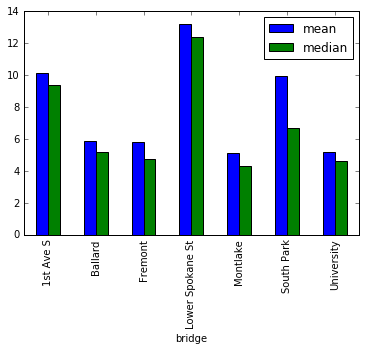

In [214]:
plotdf = pd.DataFrame([duration_df.groupby('bridge')['minutes'].mean(),
 duration_df.groupby('bridge')['minutes'].median()]).T
plotdf.columns = ['mean','median']
plotdf.plot(kind='bar')

/Library/Python/2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


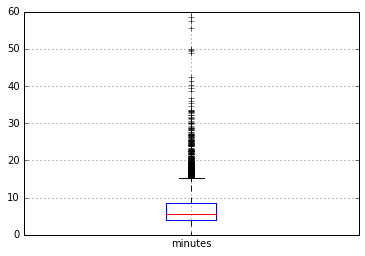

In [352]:
a = duration_df[duration_df['minutes'] < 60].boxplot(column='minutes')

In [228]:
# Shows some outliers we can remove.

# How many openings are more than 60 min?
print duration_df['minutes'].max()
print len(duration_df[duration_df['minutes'] > 90])
print len(duration_df[duration_df['minutes'] > 60])
print len(duration_df[duration_df['minutes'] > 45])
print len(duration_df[duration_df['minutes'] > 30])
print len(duration_df)

1234.31666667
3
5
12
40
10286


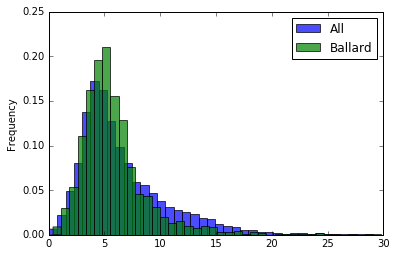

In [319]:
bridge_name = 'Ballard'
all_bridges = duration_df[duration_df['minutes'] < 30]['minutes'].plot.hist(bins=40, alpha=0.7, normed=1)
temp_bridge = duration_df[duration_df['bridge'] == bridge_name]
one_bridge = temp_bridge[temp_bridge['minutes'] < 30]['minutes'].plot.hist(bins=40, alpha=0.7, normed=1)
all_bridges.legend(['All',bridge_name])

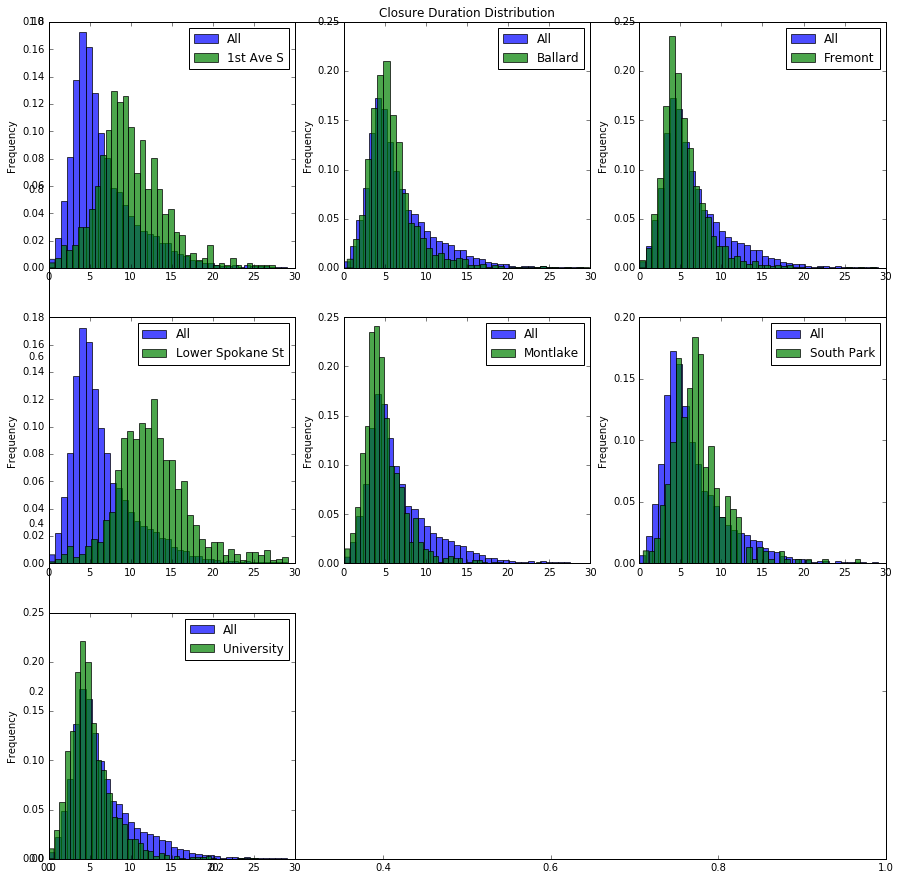

In [347]:

fig1 = plt.figure(figsize=(15,15), )
plt.title('Closure Duration Distribution')
chrt = 0
for bridge_name in df.groupby('bridge').count().index:
    chrt += 1
    ax = fig1.add_subplot(3,3,chrt)
    all_bridges = duration_df[duration_df['minutes'] < 30]['minutes'].plot.hist(bins=40, alpha=0.7, normed=1, ax=ax)
    temp_bridge = duration_df[duration_df['bridge'] == bridge_name]
    one_bridge = temp_bridge[temp_bridge['minutes'] < 30]['minutes'].plot.hist(bins=40, alpha=0.7, normed=1, ax=ax)
    all_bridges.legend(['All',bridge_name])
    

In [348]:
# Next steps:
# save this as figs and store for use in the dashboard

/Library/Python/2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


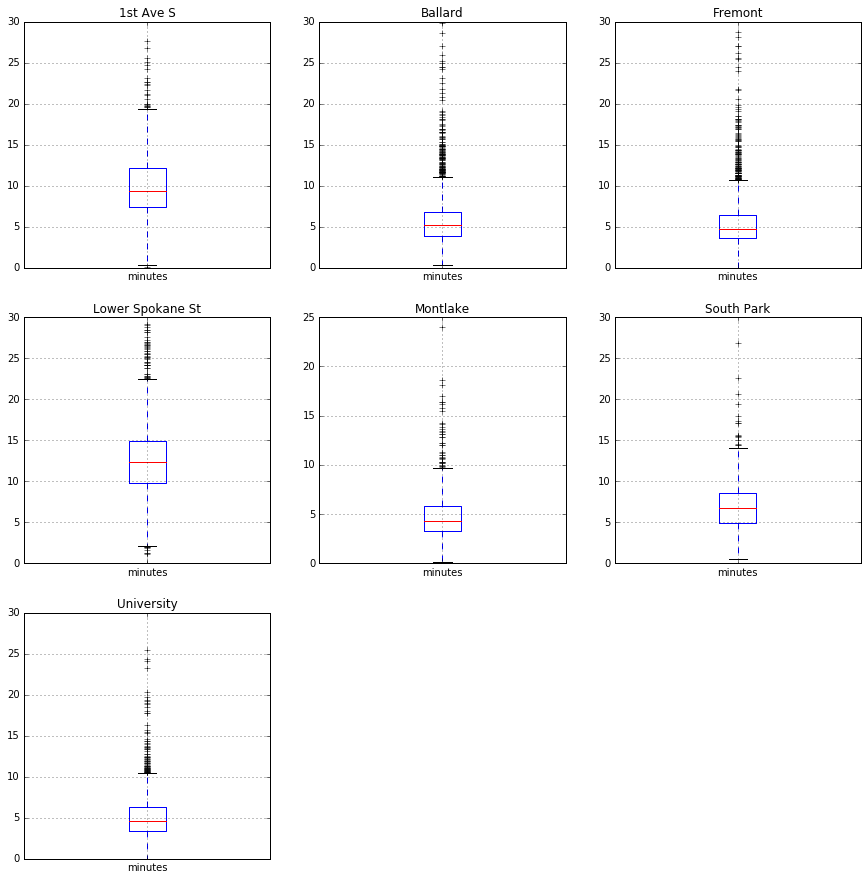

In [362]:
fig1 = plt.figure(figsize=(15,15), )
chrt = 0
for bridge_name in df.groupby('bridge').count().index:
    chrt += 1
    ax = fig1.add_subplot(3,3,chrt)
    temp_bridge = duration_df[duration_df['bridge'] == bridge_name]
    one_bridge = temp_bridge[temp_bridge['minutes'] < 30].boxplot(column='minutes')
    ax.set_title(bridge_name)